# Switch between ONAN and ONAF

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from transformer_thermal_model.cooler import CoolerType
from transformer_thermal_model.model import Model
from transformer_thermal_model.schemas import InputProfile, UserTransformerSpecifications
from transformer_thermal_model.schemas.thermal_model import FanSwitchConfig, ONAFSwitch
from transformer_thermal_model.transformer import PowerTransformer

In [2]:
datetime_index = [pd.to_datetime("2025-01-01 00:00:00") + pd.Timedelta(minutes=15 * i) for i in np.arange(0, 288)]

load_series = pd.Series(data=np.sin(np.arange(0, 288) * 900 * 2 * np.pi * 1 / 43200) * 500 + 1500, index=datetime_index)
ambient_series = pd.Series(data=20, index=datetime_index)

In [3]:
# Create an input object with the profiles
my_profile_input = InputProfile.create(
    datetime_index=datetime_index, load_profile=load_series, ambient_temperature_profile=ambient_series
)

In [ ]:
my_transformer_specifications = UserTransformerSpecifications(
    load_loss=160000,  # Transformer load loss [W]
    nom_load_sec_side=3000,  # Transformer nominal current secondary side [A]
    no_load_loss=70000,  # Transformer no-load loss [W]
    amb_temp_surcharge=10,  # Ambient temperature surcharge [K]
    time_const_oil=150,  # Time constant oil [min]
    time_const_windings=7,  # Time constant windings [min]
    top_oil_temp_rise=50.5,  # Top-oil temperature rise [K]
    winding_oil_gradient=23,  # Winding oil gradient (worst case) [K]
    end_temp_reduction=0,  # Lowering of the end temperature with respect to the current specification [K]
    hot_spot_fac=1.2,  # Hot-spot factor [-]
    oil_const_k11=0.5,  # Oil constant k11 [-]
    winding_const_k21=2.0,  # Winding constant k21 [-]
    winding_const_k22=2.0,  # Winding constant k22 [-]
    oil_exp_x=0.8,  # Oil exponent x [-]
    winding_exp_y=1.3,  # Winding exponent x [-]
)

onaf_switch = ONAFSwitch(
    temperature_threshold=FanSwitchConfig(activation_temp=85, deactivation_temp=75),
    nom_load_sec_side_ONAN=1600,
    top_oil_temp_rise_ONAN=50.5,
    winding_oil_gradient_ONAN=23,
    hot_spot_fac_ONAN=1.2,
)

my_transformer = PowerTransformer(
    user_specs=my_transformer_specifications, cooling_type=CoolerType.ONAF, ONAF_switch=onaf_switch
)

In [12]:
my_model = Model(temperature_profile=my_profile_input, transformer=my_transformer)

results = my_model.run()

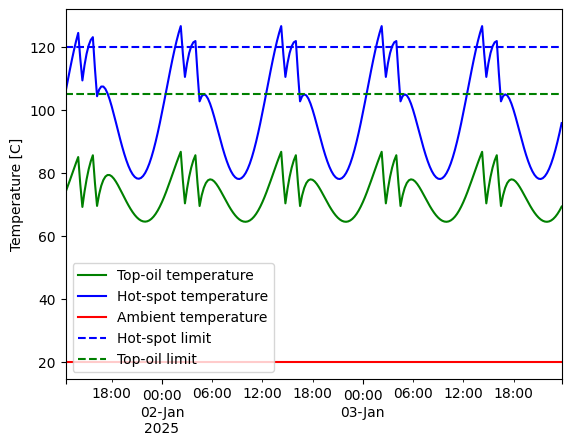

In [13]:
start_time = datetime_index[0] + pd.Timedelta(my_transformer.specs.time_const_oil * 5, "m")

fig = plt.figure()
ax = results.top_oil_temp_profile.loc[start_time::].plot(label="Top-oil temperature", color="green")
results.hot_spot_temp_profile.loc[start_time::].plot(label="Hot-spot temperature", color="blue")
ambient_series.loc[start_time::].plot(label="Ambient temperature", color="red")
ax.set_ylabel("Temperature [C]")
ax.hlines(120, datetime_index[0], datetime_index[-1], linestyles="dashed", label="Hot-spot limit", color="blue")
ax.hlines(105, datetime_index[0], datetime_index[-1], linestyles="dashed", label="Top-oil limit", color="green")
ax.legend(loc="lower left")